### 라이브러리 불러오기

In [1]:
import mysql.connector
import os
from dotenv import load_dotenv
import pandas as pd

#시각화 관련
from matplotlib import rc
from matplotlib import font_manager
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession

### 데이터 가져오기

In [2]:
load_dotenv()

host_ip = os.getenv('host_ip')
DATABASE = os.getenv('DATABASE')
user_id = os.getenv('user_id')
user_password = os.getenv('user_password')

# MySQl 연결
conn = mysql.connector.connect(
    host = host_ip, #localhost 또는 EC2의 EIP
    user = user_id,
    password = user_password,
    database = DATABASE
)
conn


In [3]:
# 커서 생성
cursor = conn.cursor(buffered=True)

# 쿼리 실행
cursor.execute("SELECT * FROM tbAPTPrice;")

# 데이터를 Pandas DataFrame으로 변환
columns = [desc[0] for desc in cursor.description]  # 컬럼명 가져오기
data = cursor.fetchall()  # 데이터 가져오기

df_tbAPTPrice = pd.DataFrame(data, columns=columns)  # DataFrame 생성

# DataFrame 출력
print(df_tbAPTPrice)

# 커넥션 닫기
cursor.close()

        접수연도  자치구코드  자치구명  법정동코드 법정동명 지번구분 지번구분명    본번    부번           건물명  \
0       2017  11710   송파구  10500  석촌동    1    대지  0282  0000          은하빌라   
1       2017  11560  영등포구  13200  신길동                                        
2       2017  11230  동대문구  10600  장안동    1    대지  0336  0000  장안현대홈타운(336)   
3       2017  11590   동작구  10200  상도동                                        
4       2017  11500   강서구  10300  화곡동    1    대지  0330  0043         예지빌라트   
...      ...    ...   ...    ...  ...  ...   ...   ...   ...           ...   
856306  2024  11680   강남구  10100  역삼동                                        
856307  2024  11290   성북구  13500  종암동    1    대지  0134  0000        래미안라센트   
856308  2024  11260   중랑구  10400   묵동    1    대지  0020  0000       신내대림아파트   
856309  2024  11680   강남구  11800  도곡동    1    대지  0967  0000            경남   
856310  2024  11620   관악구  10100  봉천동    1    대지  1712  0000      관악드림(동아)   

        ... 토지면적_m2   층 권리구분 취소일  건축년도   건물용도  신고구분 신고_공인중개사_지역

True

In [4]:
df = df_tbAPTPrice.copy()

### 탐색적 데이터 분석 및 전처리

In [5]:
df.head(3)

,접수연도,자치구코드,자치구명,법정동코드,법정동명,지번구분,지번구분명,본번,부번,건물명,...,토지면적_m2,층,권리구분,취소일,건축년도,건물용도,신고구분,신고_공인중개사_지역,계약일_DATE,idx
0,2017,11710,송파구,10500,석촌동,1,대지,0282,0000,은하빌라,...,36,3,,,2004,연립다세대,,,2017-08-08,1
1,2017,11560,영등포구,13200,신길동,,,,,,...,86,,,,1992,단독다가구,,,2017-08-08,2
2,2017,11230,동대문구,10600,장안동,1,대지,0336,0000,장안현대홈타운(336),...,0,15,,,2003,아파트,,,2017-08-08,3


#### 컬럼명 영문화

In [6]:
kor_col_list = df_tbAPTPrice.columns.to_list()
eng_col_list = ['sumbit_year', 'jachigu_code', 'jachigu_name', 'law_code', 'law_name', 'jibun_gubun', 'jibun_name', 'real_num', 'extra_num', 'building_name', 'building_price', 'building_size', 'land_size', 'floor', 'right_gubun', 'cancel_date', 'building_year', 'building_usage', 'singo_gubun', 'agent_area',  'contract_date', 'idx']

In [7]:
df = df.rename(columns = {i:j for i,j in zip(kor_col_list, eng_col_list)})
df

,sumbit_year,jachigu_code,jachigu_name,law_code,law_name,jibun_gubun,jibun_name,real_num,extra_num,building_name,...,land_size,floor,right_gubun,cancel_date,building_year,building_usage,singo_gubun,agent_area,contract_date,idx
0,2017,11710,송파구,10500,석촌동,1,대지,0282,0000,은하빌라,...,36,3,,,2004,연립다세대,,,2017-08-08,1
1,2017,11560,영등포구,13200,신길동,,,,,,...,86,,,,1992,단독다가구,,,2017-08-08,2
2,2017,11230,동대문구,10600,장안동,1,대지,0336,0000,장안현대홈타운(336),...,0,15,,,2003,아파트,,,2017-08-08,3
3,2017,11590,동작구,10200,상도동,,,,,,...,198,,,,1974,단독다가구,,,2017-08-08,4
4,2017,11500,강서구,10300,화곡동,1,대지,0330,0043,예지빌라트,...,26.63,1,,,2007,연립다세대,,,2017-08-08,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856306,2024,11680,강남구,10100,역삼동,,,,,,...,179,,,,1981,단독다가구,중개거래,서울 강남구,2024-07-24,856307
856307,2024,11290,성북구,13500,종암동,1,대지,0134,0000,래미안라센트,...,0,14,,,2011,아파트,중개거래,서울 성북구,2024-07-24,856308
856308,2024,11260,중랑구,10400,묵동,1,대지,0020,0000,신내대림아파트,...,0,4,,,1995,아파트,중개거래,서울 중랑구,2024-07-24,856309
856309,2024,11680,강남구,11800,도곡동,1,대지,0967,0000,경남,...,0,6,,,2005,아파트,중개거래,서울 강남구,2024-07-24,856310


#### 결측치 및 불필요 컬럼 삭제

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856311 entries, 0 to 856310
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   sumbit_year     856311 non-null  object
 1   jachigu_code    856311 non-null  object
 2   jachigu_name    856311 non-null  object
 3   law_code        856311 non-null  object
 4   law_name        856311 non-null  object
 5   jibun_gubun     856311 non-null  object
 6   jibun_name      856311 non-null  object
 7   real_num        856311 non-null  object
 8   extra_num       856311 non-null  object
 9   building_name   856311 non-null  object
 10  building_price  856311 non-null  object
 11  building_size   856311 non-null  object
 12  land_size       856311 non-null  object
 13  floor           856311 non-null  object
 14  right_gubun     856311 non-null  object
 15  cancel_date     856311 non-null  object
 16  building_year   852600 non-null  object
 17  building_usage  856311 non-nu

In [9]:
df.columns

Index(['sumbit_year', 'jachigu_code', 'jachigu_name', 'law_code', 'law_name',
       'jibun_gubun', 'jibun_name', 'real_num', 'extra_num', 'building_name',
       'building_price', 'building_size', 'land_size', 'floor', 'right_gubun',
       'cancel_date', 'building_year', 'building_usage', 'singo_gubun',
       'agent_area', 'contract_date', 'idx'],
      dtype='object')

In [11]:
# features : 접수연도, 자치구코드, 법정동코드, 건물 사이즈, 건물연식, 건물용도
# target : 건물 가격

only_need_cols = ['sumbit_year'
                , 'jachigu_code'
                , 'law_code'
                , 'building_price'
                , 'building_size'
                , 'building_year'
                , 'building_usage'               
                ]

df = df[only_need_cols]

In [12]:
### 컬럼 타입 변경
df['building_price'] = pd.to_numeric(df['building_price'])
df['building_size'] = pd.to_numeric(df['building_size'])
df['building_year'] = pd.to_numeric(df['building_year'])

df

,sumbit_year,jachigu_code,law_code,building_price,building_size,building_year,building_usage
0,2017,11710,10500,42000,73.12,2004.0,연립다세대
1,2017,11560,13200,60000,127.44,1992.0,단독다가구
2,2017,11230,10600,52200,84.87,2003.0,아파트
3,2017,11590,10200,69000,76.40,1974.0,단독다가구
4,2017,11500,10300,9000,34.68,2007.0,연립다세대
...,...,...,...,...,...,...,...
856306,2024,11680,10100,420000,216.97,1981.0,단독다가구
856307,2024,11290,13500,109500,84.99,2011.0,아파트
856308,2024,11260,10400,104800,126.28,1995.0,아파트
856309,2024,11680,11800,195000,84.94,2005.0,아파트


In [13]:
# 자치구코드, 법정동코드로 그룹화해서 평균값을 반올림해서 넣어주자
# 왜냐면, 그 자치구의 그 법정동들을 비슷하게 지어졌을 것이라는 전제이다.
df[df['building_year'].isnull() == True]
groupby_df = df.groupby(['jachigu_code', 'law_code']).mean().reset_index()
groupby_df['building_year_4'] = round(groupby_df[['jachigu_code', 'law_code', 'building_year']]['building_year'], 0)
groupby_df

,jachigu_code,law_code,building_price,building_size,building_year,building_year_4
0,11110,10100,120215.477419,146.156774,1996.348387,1996.0
1,11110,10200,38404.229167,59.191563,1995.697917,1996.0
2,11110,10300,105000.000000,16.890000,1900.000000,1900.0
3,11110,10400,108321.212121,121.200909,1987.424242,1987.0
4,11110,10500,166785.833333,106.680000,1965.958333,1966.0
...,...,...,...,...,...,...
422,11740,10700,59538.126254,72.541742,2006.545970,2007.0
423,11740,10800,50850.010815,72.156793,2000.096110,2000.0
424,11740,10900,41875.100426,61.879241,1990.506757,1991.0
425,11740,11000,53304.587237,63.423764,1998.190283,1998.0


In [14]:
merge_df = df.merge(groupby_df[['jachigu_code', 'law_code', 'building_year_4']]
                    , on = ['jachigu_code', 'law_code']
                    )

merge_df[merge_df['building_year'].isnull() == True]

merge_df['building_year'].fillna('building_year_4', inplace=True)

df = merge_df.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856311 entries, 0 to 856310
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   sumbit_year      856311 non-null  object 
 1   jachigu_code     856311 non-null  object 
 2   law_code         856311 non-null  object 
 3   building_price   856311 non-null  int64  
 4   building_size    856311 non-null  float64
 5   building_year    856311 non-null  object 
 6   building_usage   856311 non-null  object 
 7   building_year_4  856311 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 58.8+ MB


In [15]:
df.describe()

,building_price,building_size,building_year_4
count,8.563110e+05,856311.000000,856311.000000
mean,5.860996e+04,69.911404,1963.618511
std,7.339973e+04,68.943272,78.807530
min,1.700000e+03,4.500000,0.000000
25%,2.250000e+04,37.070000,1972.000000
50%,3.650000e+04,57.680000,1992.000000
75%,7.000000e+04,84.650000,2001.000000
max,1.108778e+07,3619.840000,2018.000000


1950년 미만 데이터 개수 : 170492
1950년 미만 삭제 후 데이터 개수 : 685819


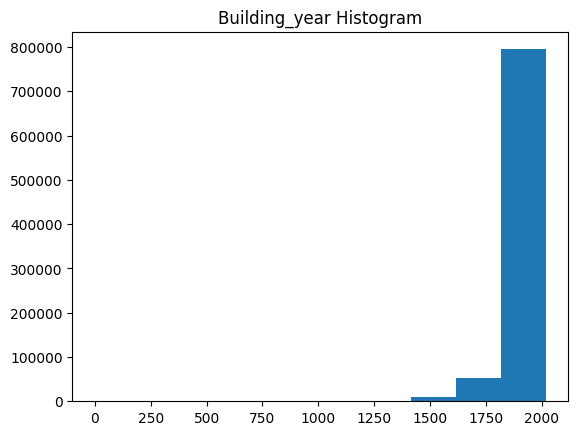

In [16]:
### builng_year_4의 분포를 확인해서, 값이 이상한 것은 조치를 취하자
plt.hist(x = df['building_year_4']
         , bins = 10
         )
plt.title('Building_year Histogram')

# 건물 연식이 1950년 미만인 것은 삭제하자
print(f"1950년 미만 데이터 개수 : {df[df['building_year_4'] < 1950].shape[0]}")

df = df[df['building_year_4'] > 1950]

print(f"1950년 미만 삭제 후 데이터 개수 : {df.shape[0]}")

Text(0.5, 1.0, 'After removing the old buildings')

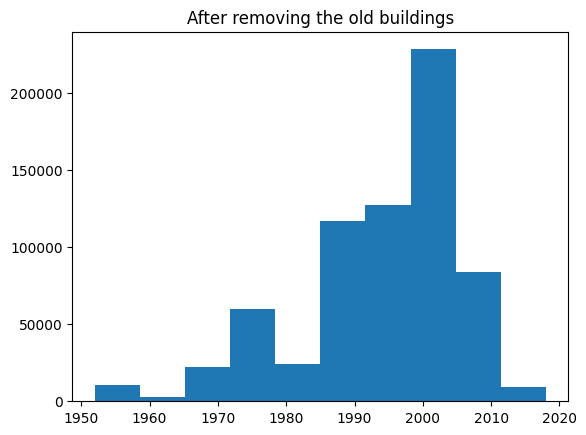

In [18]:
plt.hist(df['building_year_4']
         , bins = 10)

plt.title('After removing the old buildings')

In [19]:
# 10년마다 년대 구분해서 원핫 인코딩 하자
df['building_year_range'] = (df['building_year_4']//10) * 10
df['building_year_range'] = df['building_year_range'].astype('int').astype('object')
df.drop('building_year_4', axis =1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685819 entries, 0 to 856309
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sumbit_year          685819 non-null  object 
 1   jachigu_code         685819 non-null  object 
 2   law_code             685819 non-null  object 
 3   building_price       685819 non-null  int64  
 4   building_size        685819 non-null  float64
 5   building_year        685819 non-null  object 
 6   building_usage       685819 non-null  object 
 7   building_year_range  685819 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 47.1+ MB


In [20]:
df.drop('building_year', axis = 1, inplace = True)

In [22]:
# 다른 컬럼 특이사항 확인
print(df['jachigu_code'].unique())
print(df['law_code'].unique())
print(df['building_usage'].unique())

['11710' '11230' '11590' '11500' '11380' '11320' '11440' '11680' '11470'
 '11260' '11560' '11350' '11410' '11620' '11290' '11215' '11530' '11650'
 '11305' '11740' '11545' '11200' '11170' '11140' '11110']
['10500' '10600' '10200' '10300' '12300' '11100' '12500' '10700' '10900'
 '11900' '10400' '10100' '13600' '11000' '10800' '12200' '12800' '12600'
 '12000' '11700' '12100' '13300' '13500' '13000' '13100' '11200' '11300'
 '11500' '15100' '11800' '11400' '16500' '16000' '17400' '12700' '13400'
 '12900' '16200' '17500' '16300' '16800' '13700' '12400' '14700' '14900'
 '17300' '13200' '14000' '16600' '16700' '18600' '18300' '18400' '16900'
 '18700' '17100' '13900' '14300' '15700' '11600' '18200' '17200' '15900'
 '18100' '17000' '14400' '18500' '15300' '14800' '14600' '16400' '14500'
 '14200' '13800' '15200' '15400' '15500' '15800' '16100' '14100' '15000']
['연립다세대' '오피스텔' '아파트' '단독다가구']


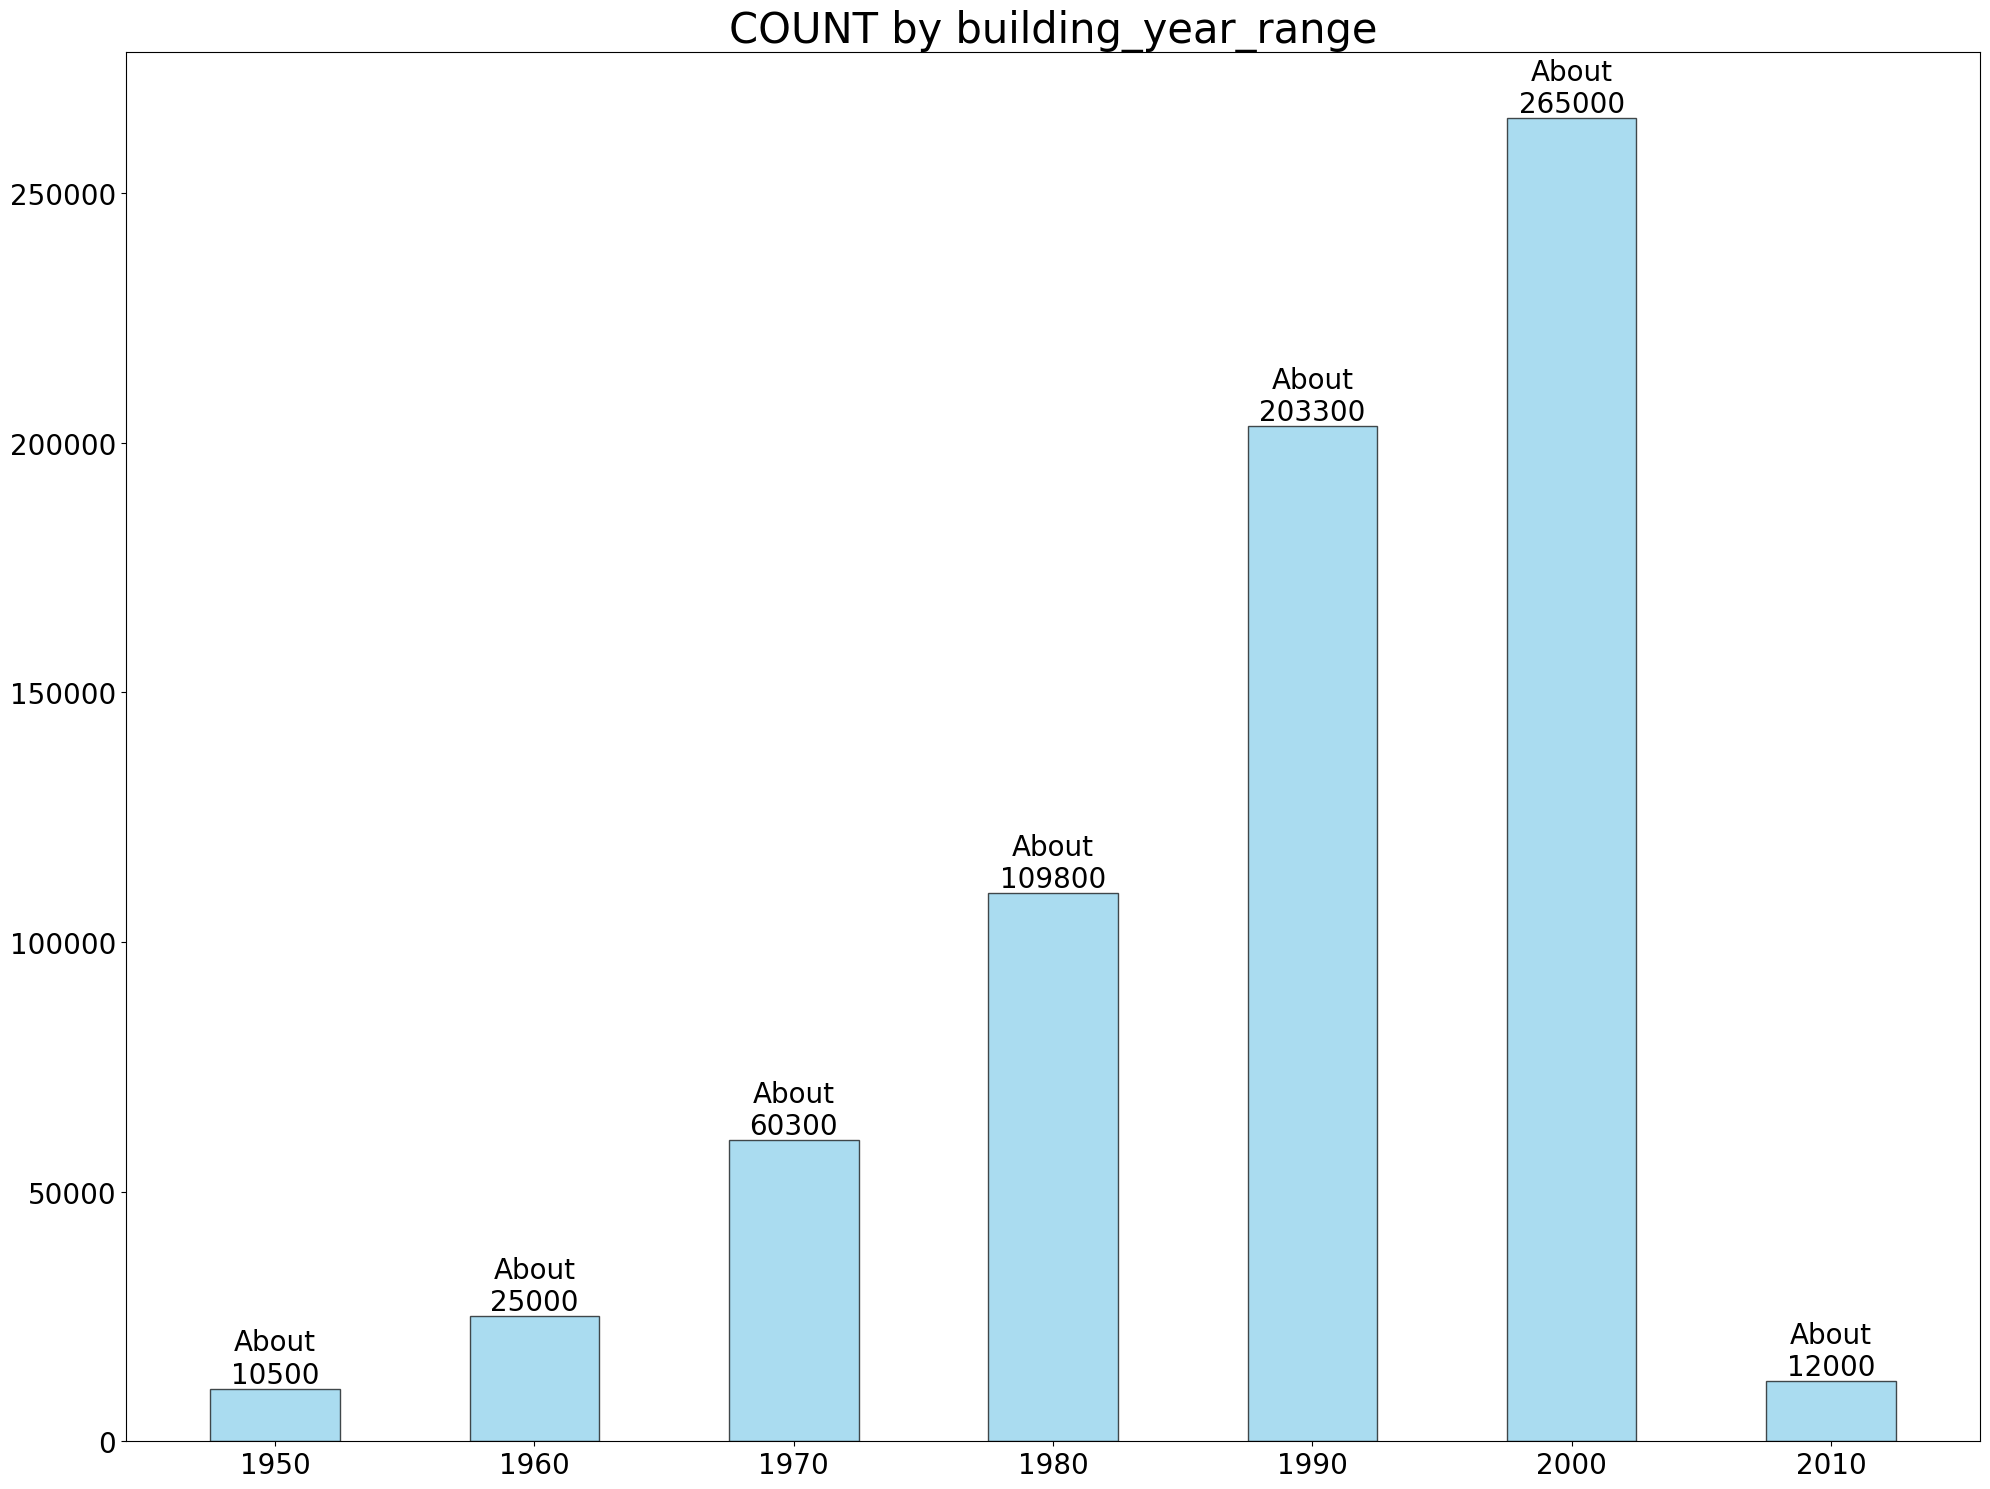

In [23]:
plt.figure(figsize=(20, 15))

charts = plt.bar(x = sorted(df['building_year_range'].unique())
                , height = df['building_year_range'].value_counts().sort_index()
                , width= 5
                , color = 'skyblue'
                , edgecolor = 'black'
                , alpha = 0.7
                )


for data in charts:
    plt.text(
        data.get_x() + data.get_width() / 2
        , data.get_height() + 0.5
        , f'''About
{round(int(data.get_height()), -2)}'''
        , ha = 'center'
        , va = 'bottom'
        , fontsize = 20
    )

plt.title('COUNT by building_year_range', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tight_layout()


In [28]:
list(sorted(df['sumbit_year'].unique()))

['2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']

In [32]:
dir(plt)

['Annotation',
 'Arrow',
 'Artist',
 'AutoLocator',
 'Axes',
 'Button',
 'Circle',
 'Enum',
 'ExitStack',
 'Figure',
 'FigureBase',
 'FigureCanvasBase',
 'FigureManagerBase',
 'FixedFormatter',
 'FixedLocator',
 'FormatStrFormatter',
 'Formatter',
 'FuncFormatter',
 'GridSpec',
 'IndexLocator',
 'Line2D',
 'LinearLocator',
 'Locator',
 'LogFormatter',
 'LogFormatterExponent',
 'LogFormatterMathtext',
 'LogLocator',
 'MaxNLocator',
 'MouseButton',
 'MultipleLocator',
 'Normalize',
 'NullFormatter',
 'NullLocator',
 'Number',
 'PolarAxes',
 'Polygon',
 'Rectangle',
 'ScalarFormatter',
 'Slider',
 'Subplot',
 'SubplotSpec',
 'Text',
 'TickHelper',
 'Widget',
 '_REPL_DISPLAYHOOK',
 '_ReplDisplayHook',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_api',
 '_auto_draw_if_interactive',
 '_backend_mod',
 '_copy_docstring_and_deprecators',
 '_docstring',
 '_draw_all_if_interactive',
 '_get_backend_mod',
 '_get_pyplot_commands

In [57]:
df.groupby(['sumbit_year', 'jachigu_code']).mean().reset_index()

,sumbit_year,jachigu_code,building_price,building_size
0,2017,11110,47572.083891,78.046252
1,2017,11140,54810.145858,79.185222
2,2017,11170,87191.657541,91.797341
3,2017,11200,59516.990213,83.228151
4,2017,11215,50742.126516,83.145979
...,...,...,...,...
195,2024,11620,51895.714998,65.944693
196,2024,11650,126639.292747,69.771343
197,2024,11680,201668.620729,84.183125
198,2024,11710,124672.812409,73.240167


TypeError: plot() got an unexpected keyword argument 'x'

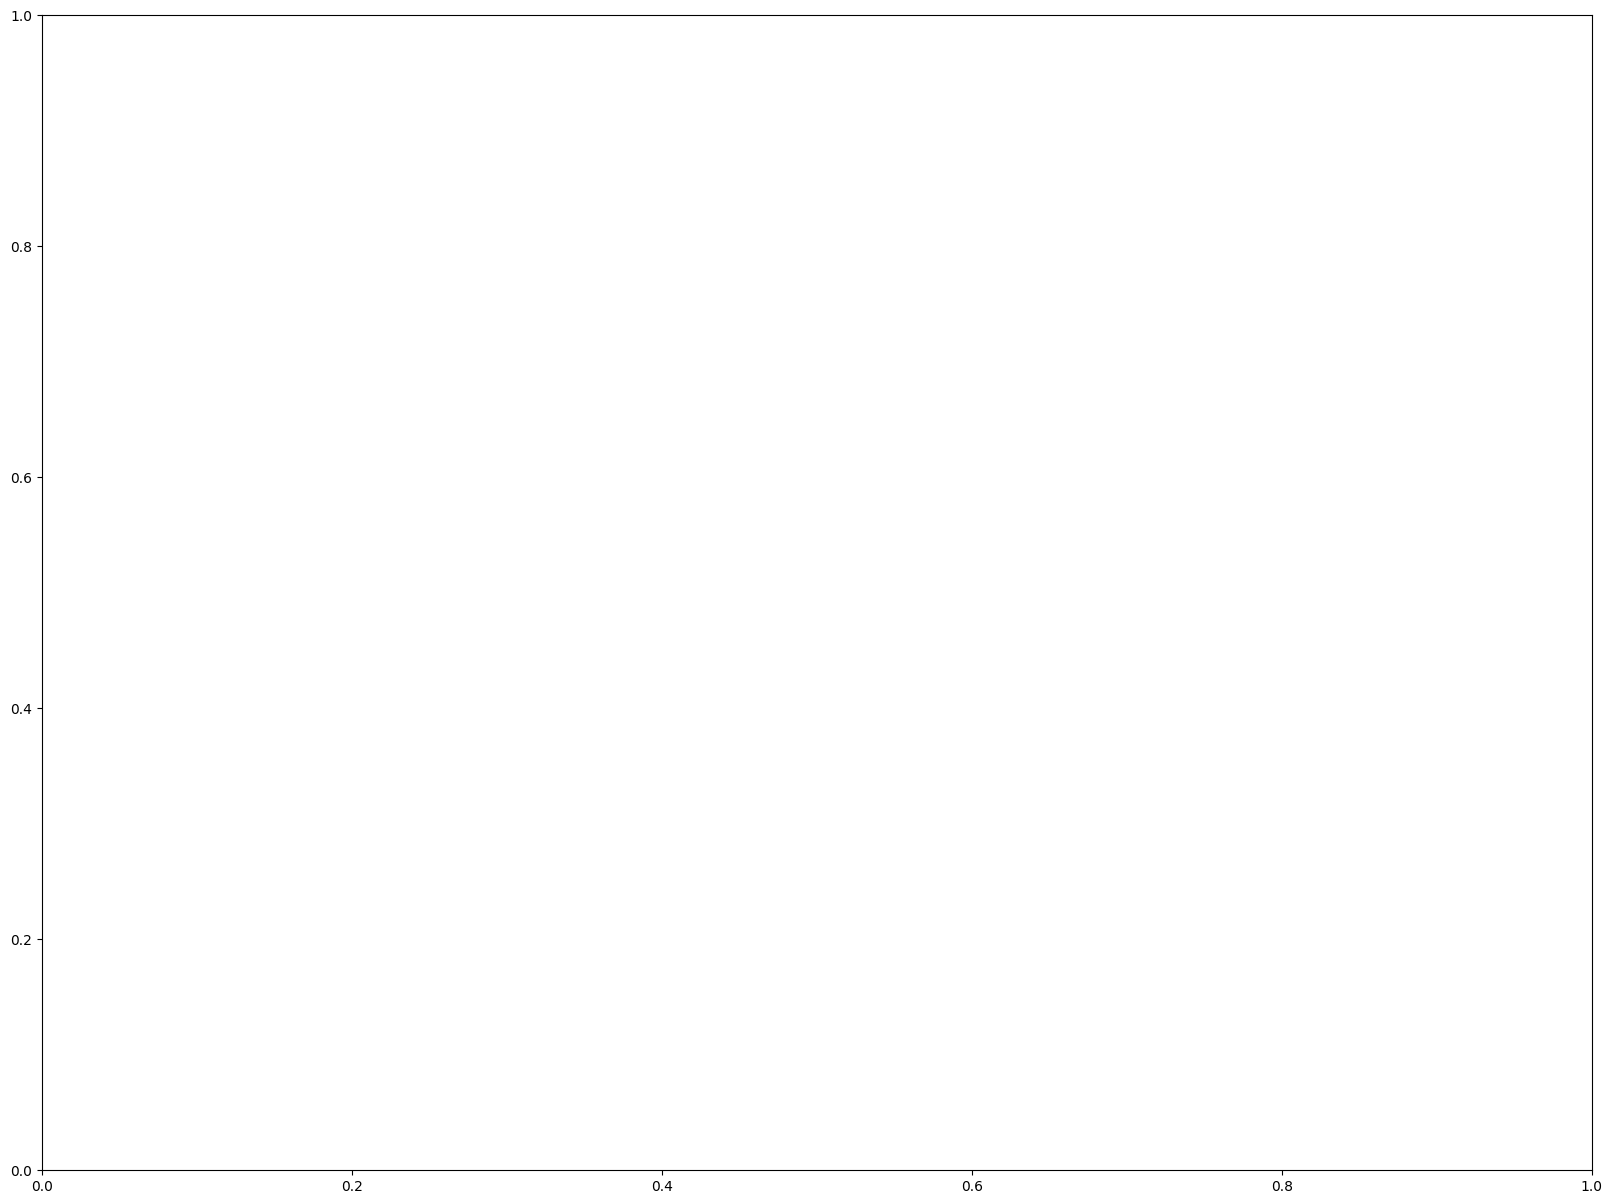

In [ ]:
df[df['building_year'].isnull() == True]['building_year']


In [125]:
# 결측치 확인
df.info()

# building_year에 null이 많다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856311 entries, 0 to 856310
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jachigu_code    856311 non-null  object 
 1   law_code        856311 non-null  object 
 2   building_price  856311 non-null  int64  
 3   building_size   856311 non-null  float64
 4   building_year   852600 non-null  float64
 5   building_usage  856311 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 39.2+ MB


In [ ]:
##

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856311 entries, 0 to 856310
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   jachigu_code    856311 non-null  object
 1   law_code        856311 non-null  object
 2   building_price  856311 non-null  object
 3   building_size   856311 non-null  object
 4   building_year   852600 non-null  object
 5   building_usage  856311 non-null  object
dtypes: object(6)
memory usage: 39.2+ MB


In [9]:
pd_df.sort_values(by = ['접수연도', 'idx'], inplace = True)

pd_df.shape, pd_df.dtypes, pd_df.columns

((856311, 22),
 접수연도           object
 자치구코드          object
 자치구명           object
 법정동코드          object
 법정동명           object
 지번구분           object
 지번구분명          object
 본번             object
 부번             object
 건물명            object
 물건금액_만원        object
 건물면적_m2        object
 토지면적_m2        object
 층              object
 권리구분           object
 취소일            object
 건축년도           object
 건물용도           object
 신고구분           object
 신고_공인중개사_지역    object
 계약일_DATE       object
 idx             int64
 dtype: object,
 Index(['접수연도', '자치구코드', '자치구명', '법정동코드', '법정동명', '지번구분', '지번구분명', '본번', '부번',
        '건물명', '물건금액_만원', '건물면적_m2', '토지면적_m2', '층', '권리구분', '취소일', '건축년도',
        '건물용도', '신고구분', '신고_공인중개사_지역', '계약일_DATE', 'idx'],
       dtype='object'))

In [10]:
pd_df.drop_duplicates(subset = '자치구코드')['자치구코드']

0         11710
1         11560
2         11230
3         11590
4         11500
5         11380
6         11320
9         11410
10        11440
11        11680
12        11470
13        11260
16        11350
31        11200
43        11620
49        11215
50        11290
62        11530
67        11650
69        11305
71        11740
88        11545
131       11140
220       11170
431       11110
701892    26230
Name: 자치구코드, dtype: object

In [12]:
 data = pd_df\
        .groupby(['접수연도','자치구코드'])\
        .mean('물건금액_만원')\
        .reset_index()\
        .rename(columns={'idx': 'mean_building_price'})

data

,접수연도,자치구코드,mean_building_price
0,2017,11110,131351.226947
1,2017,11140,127924.033071
2,2017,11170,134699.606940
3,2017,11200,129799.030183
4,2017,11215,131265.427246
...,...,...,...
196,2024,11650,730672.906186
197,2024,11680,740442.019773
198,2024,11710,734221.908615
199,2024,11740,732828.116606


In [ ]:

# 고유한 '자치구코드' 리스트 가져오기
unique_codes = pd_df['자치구코드'].drop_duplicates()

# subplot 레이아웃 설정
num_plots = len(unique_codes)  # 필요한 subplot 개수
rows = (num_plots // 3) + 1  # 행 개수 (3열로 설정)
cols = 3                     # 열 개수

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))  # 전체 subplot 크기 조정
axes = axes.flatten()  # Axes를 1차원 배열로 변환 (루프에서 쉽게 접근 가능)

# 각 자치구코드별로 그래프 그리기
for idx, i in enumerate(unique_codes):
    ax = axes[idx]  # 현재 subplot 선택
    
    # 데이터 필터링 및 그래프 그리기
    data = pd_df[pd_df['자치구코드'] == i]\
        .groupby(['자치구코드', '접수연도'])\
        .mean('물건금액_만원')\
        .reset_index()\
        .rename(columns={'idx': 'mean_building_price'})
    
    sns.lineplot(
        data=data,
        x='접수연도',
        y='mean_building_price',
        ax=ax
    )
    
    # 제목 설정
    ax.set_title(f'자치구코드: {i}', fontsize=10)
    
    # 각 데이터 포인트에 값 표시
    for x, y in zip(data['접수연도'], data['mean_building_price']):
        ax.text(x, y, f'{y:.2f}', fontsize=8, color='black', ha='center')

# 남은 subplot 숨기기 (필요 없을 때)
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

# 레이아웃 정리
plt.tight_layout()
plt.show()

In [ ]:

# 고유한 '자치구코드' 리스트 가져오기
unique_codes = pd_df['건물용도'].drop_duplicates()

# subplot 레이아웃 설정
num_plots = len(unique_codes)  # 필요한 subplot 개수
rows = (num_plots // 3) + 1  # 행 개수 (3열로 설정)
cols = 3                     # 열 개수

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))  # 전체 subplot 크기 조정
axes = axes.flatten()  # Axes를 1차원 배열로 변환 (루프에서 쉽게 접근 가능)

# 각 자치구코드별로 그래프 그리기
for idx, i in enumerate(unique_codes):
    ax = axes[idx]  # 현재 subplot 선택
    
    # 데이터 필터링 및 그래프 그리기
    data = pd_df[pd_df['건물용도'] == i]\
        .groupby(['건물용도', '접수연도'])\
        .mean('물건금액_만원')\
        .reset_index()\
        .rename(columns={'idx': 'mean_building_price'})
    
    sns.lineplot(
        data=data,
        x='접수연도',
        y='mean_building_price',
        ax=ax
    )
    
    # 제목 설정
    ax.set_title(f'건물용도: {i}', fontsize=10)
        
    # 각 데이터 포인트에 값 표시
    for x, y in zip(data['접수연도'], data['mean_building_price']):
        ax.text(x, y, f'{y:.2f}', fontsize=8, color='black', ha='center')

# 남은 subplot 숨기기 (필요 없을 때)
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

# 레이아웃 정리
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 예제 데이터프레임 (pd_df는 이미 정의되어 있다고 가정)

# 고유한 자치구코드와 건축용도 조합 가져오기
unique_combinations = pd_df[['자치구코드', '건물용도']].drop_duplicates()

# subplot 레이아웃 설정
num_plots = len(unique_combinations)  # 필요한 subplot 개수
rows = (num_plots // 3) + 1           # 행 개수 (3열로 설정)
cols = 3                              # 열 개수

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))  # 전체 subplot 크기 조정
axes = axes.flatten()  # Axes를 1차원 배열로 변환

# 각 자치구와 건축용도 조합별로 그래프 그리기
for idx, (gu, usage) in enumerate(unique_combinations.values):
    ax = axes[idx]  # 현재 subplot 선택
    
    # 데이터 필터링
    data = pd_df[(pd_df['자치구코드'] == gu) & (pd_df['건물용도'] == usage)]\
        .groupby(['자치구코드', '건물용도', '접수연도'])\
        .mean('건물용도')\
        .reset_index()\
        .rename(columns={'idx': 'mean_building_price'})
    
    # 그래프 그리기
    sns.lineplot(
        data=data,
        x='접수연도',
        y='mean_building_price',
        ax=ax
    )
    
    # 제목 설정
    ax.set_title(f'자치구: {gu}, 용도: {usage}', fontsize=10)

    # 각 데이터 포인트에 값 표시
    for x, y in zip(data['접수연도'], data['mean_building_price']):
        ax.text(x, y, f'{y:.2f}', fontsize=8, color='black', ha='center')

# 남은 subplot 숨기기 (필요 없을 때)
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

# 레이아웃 정리
plt.tight_layout()
plt.show()


In [14]:
# 커서 생성
cursor = conn.cursor(buffered=True)

In [15]:
# 쿼리 실행
cursor.execute("SELECT * FROM lg_prediction;")

# 데이터를 Pandas DataFrame으로 변환
columns = [desc[0] for desc in cursor.description]  # 컬럼명 가져오기
data = cursor.fetchall()  # 데이터 가져오기

df = pd.DataFrame(data, columns=columns)  # DataFrame 생성

# DataFrame 출력
print(df)

# 커넥션 닫기
cursor.close()

        lg_idx     idx           prediction             getdate
0            1   99170   -9452.437385965139 2024-12-19 16:00:38
1            2   99174   -9173.125006051734 2024-12-19 16:00:39
2            3   99369   -8201.881638757885 2024-12-19 16:00:39
3            4   99196   -8614.501457011327 2024-12-19 16:00:39
4            5   99409  -6322.8727340474725 2024-12-19 16:00:39
...        ...     ...                  ...                 ...
333949  333950  654679     129098.928045962 2024-12-20 12:47:53
333950  333951  641805   130856.93460532837 2024-12-20 12:47:53
333951  333952  645769   121670.15716138482 2024-12-20 12:47:53
333952  333953  686479   156054.37675086968 2024-12-20 12:47:53
333953  333954  837377    139936.9200932663 2024-12-20 12:47:53

[333954 rows x 4 columns]


True

In [21]:
for i in dir(df):
    if 'join' in i:
        print(i)

_join_compat
join


In [25]:
pd_df['idx']

0              1
1              2
2              3
3              4
4              5
           ...  
856306    856307
856307    856308
856308    856309
856309    856310
856310    856311
Name: idx, Length: 856311, dtype: int64

In [47]:
tmp_df = df[df['getdate'].astype('str').str[:10] == '2024-12-20']

In [50]:
tmp_df2 = pd_df.merge(right = tmp_df, how = 'inner', left_on = 'idx', right_on = 'idx')
tmp_df2.columns

Index(['접수연도', '자치구코드', '자치구명', '법정동코드', '법정동명', '지번구분', '지번구분명', '본번', '부번',
       '건물명', '물건금액_만원', '건물면적_m2', '토지면적_m2', '층', '권리구분', '취소일', '건축년도',
       '건물용도', '신고구분', '신고_공인중개사_지역', '계약일_DATE', 'idx', 'lg_idx',
       'prediction', 'getdate'],
      dtype='object')

In [55]:
jachigu_list

['',
 '강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구']

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24332\579849934.py:40: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from current font.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24332\579849934.py:40: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24332\579849934.py:40: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from current font.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24332\579849934.py:40: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24332\579849934.py:40: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24332\579849934.py:40: UserWarning: Glyph 44032 (\N{HA

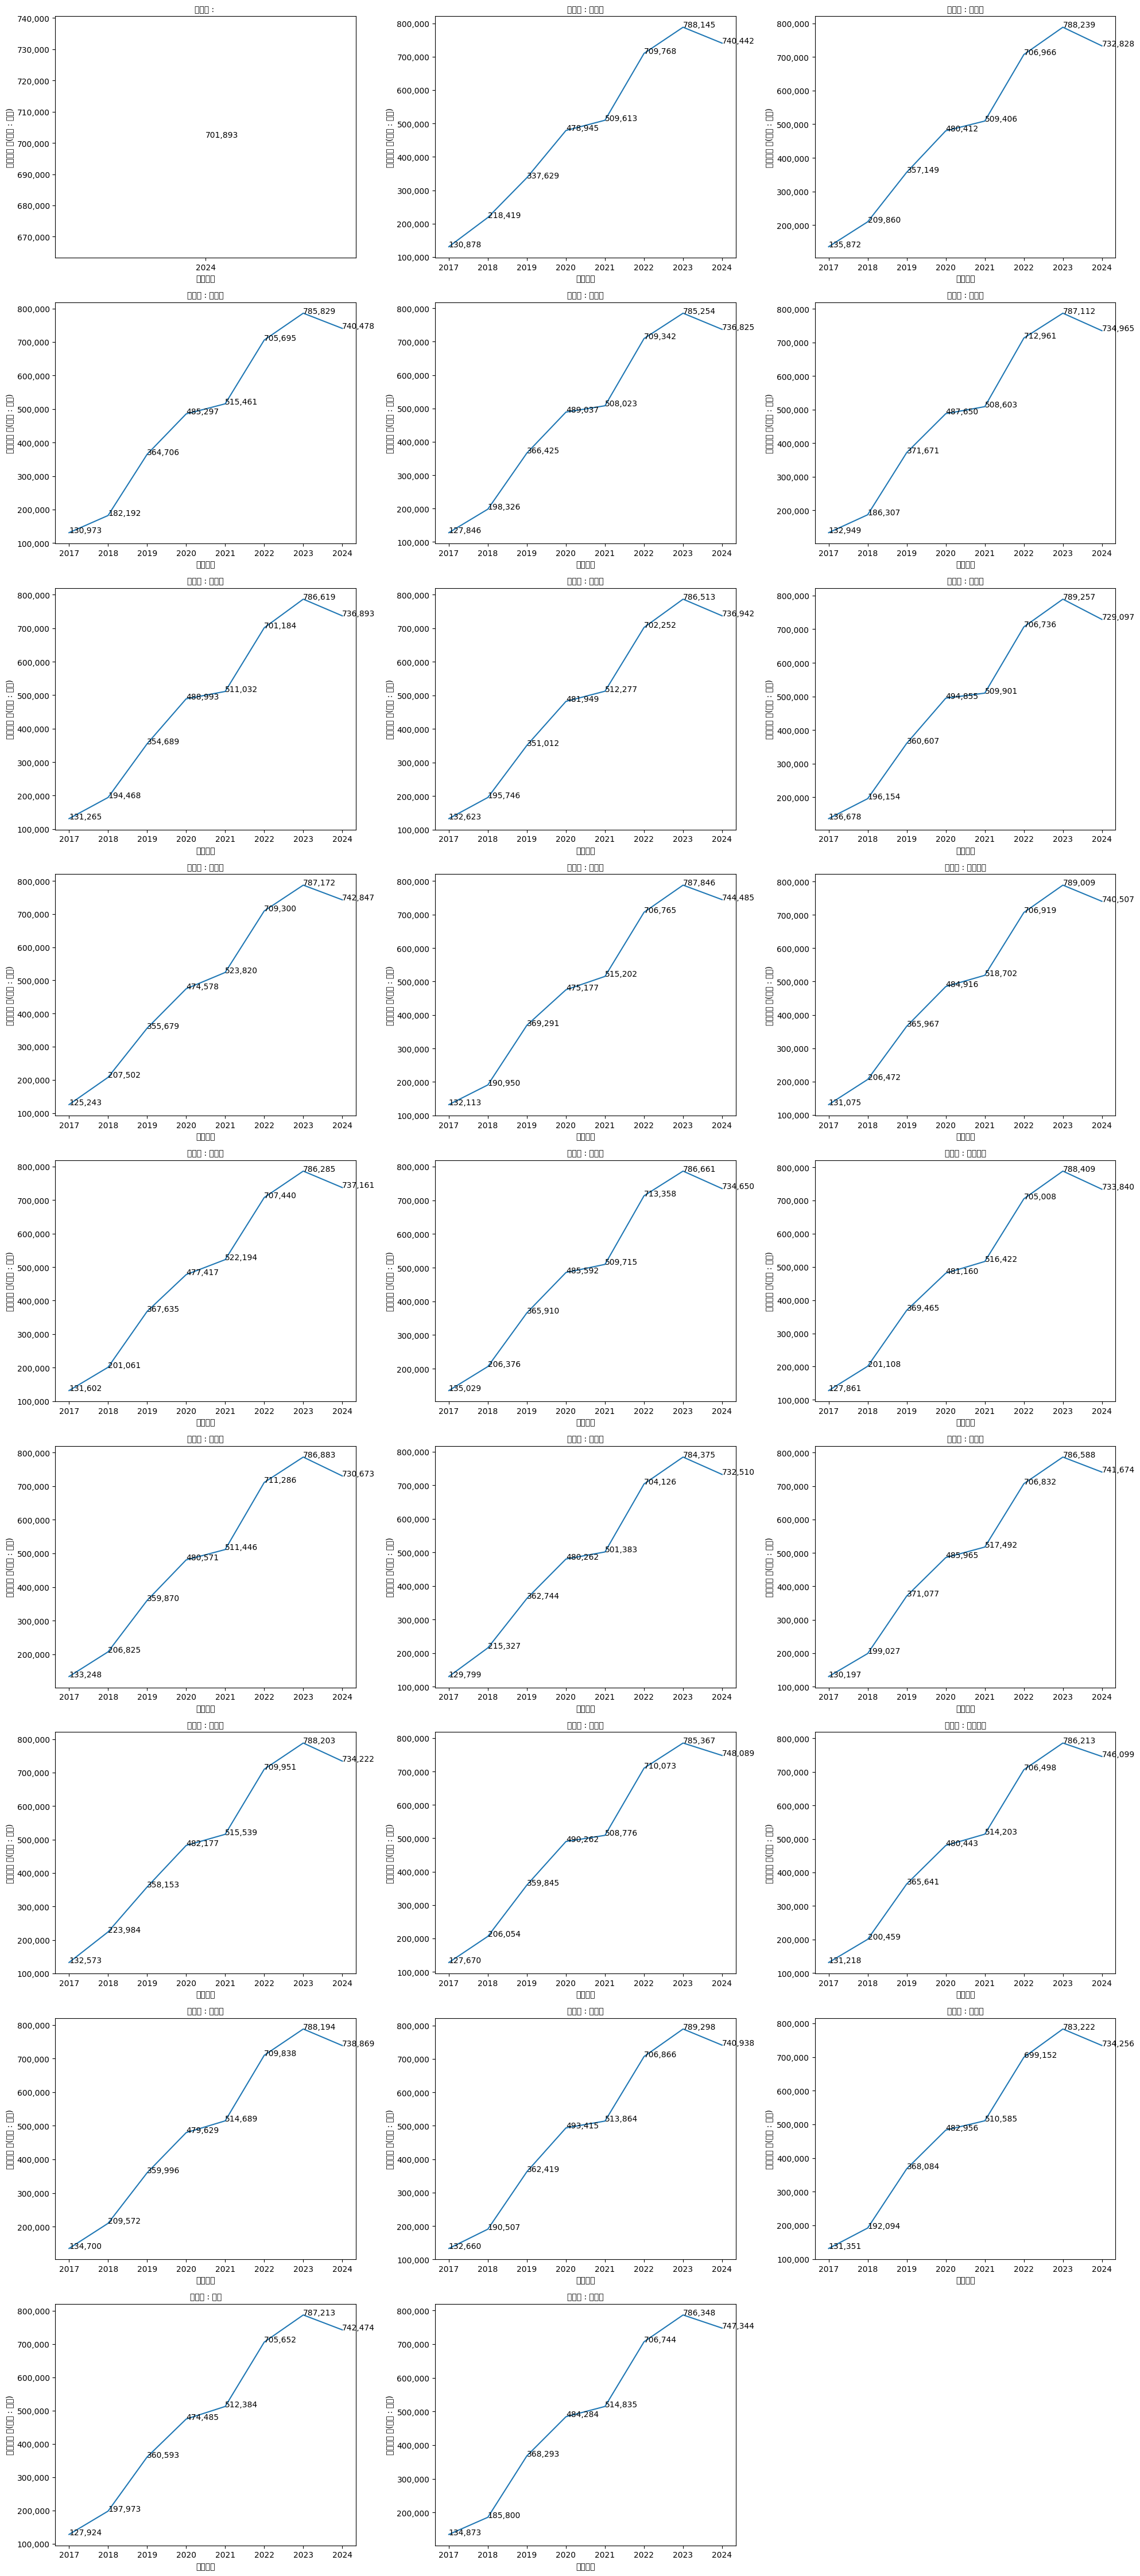

In [54]:
jachigu_list = sorted(list(pd_df['자치구명'].drop_duplicates()))

count_jachigu = len(jachigu_list)
r = len(jachigu_list) // 3 + 1
c = 3

fig, axes = plt.subplots(r,c,figsize=(20, r * 5))
axes = axes.flatten() #axes를 1차원으로 변환함으로써 for을 쉽게 돌림

for idx, i in enumerate(jachigu_list):
    ax = axes[idx]
    tmp_df = pd_df[pd_df['자치구명'] == i]\
                .groupby(['접수연도', '자치구명'])\
                .mean('prediction')\
                .reset_index()\
                .rename(columns = {'idx' : 'mean_prediction'})

    sns.lineplot(
        data = tmp_df
        , x = '접수연도'
        , y = 'mean_prediction'
        , ax = ax
    )
    
    ax.set_title(f'자치구 : {i}', fontsize = 10)
    ax.set_xlabel('거래연도')    
    ax.set_ylabel('실거래가 액(단위 : 만원)')    
    
    # 천단위 구분 기호 추가
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

    # 값 표시해주기
    for x, y in zip(tmp_df['접수연도'], tmp_df['mean_prediction']):
        ax.text(x,y, f'{y:,.0f}', fontsize = 10, color = 'black', ha = 'left')

# 필요없는 axes는 제거
for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()
